In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import torch
import sqlite3
from google.colab import drive
import sqlite3
import json
import math
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Stock data from YAHOO
import yfinance as yf


In [ ]:
# drive.mount("drive")
# con = sqlite3.connect("/content/drive/MyDrive/Our GP folder/Data/FDB/FDB.db") 
# sql_query = """SELECT name FROM sqlite_master  
#   WHERE type='table';"""
# cursor =  con.cursor()

# cursor.execute(sql_query)
# tables = [ x[0]  for x in cursor.fetchall()]

Mounted at drive


In [ ]:
stock_data = yf.download('AAPL', start='2015-01-01', end='2022-10-01')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.565701,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.873640,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.875891,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.210680,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.140915,237458000


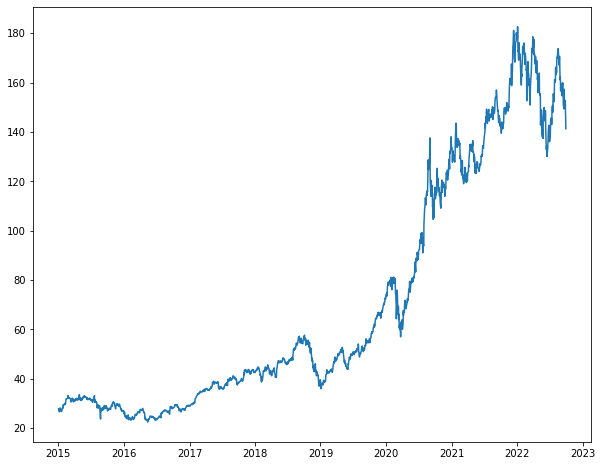

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(stock_data['Open'])

In [ ]:
len(stock_data)

1951

In [ ]:
values.shape

(1951,)

In [ ]:
# Train Dataset
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
# Test
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = scaled_data[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

In [ ]:
# importing the required libraries
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# defining the Dataset class
class DatasetYahoo(Dataset):

	def __init__(self,  x:torch.Tensor, y:torch.Tensor):
			super().__init__()
			self.x = x 
			self.y = y

	def __len__(self):
		return len(self.x)

	def __getitem__(self, index):
		return {"x": self.x[index],"y": self.y[index] }
		


train_set = DatasetYahoo(x_train, y_train)
test_set = DatasetYahoo(x_test, y_test)

# implementing dataloader on the dataset and printing per batch
train_loader = DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)


In [ ]:
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 25)
        self.fc2 = nn.Linear(25, output_size)
        
    def forward(self, x):
        # h0 = torch.zeros(2, x.size(0), 100).to(device) # num_layers * num_directions, batch_size, hidden_size
        # c0 = torch.zeros(2, x.size(0), 100).to(device)
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM1(input_size=1, hidden_size=10, num_layers=2, output_size=1).to(device)
print(model)


LSTM1(
  (lstm1): LSTM(1, 10, num_layers=2, batch_first=True)
  (lstm2): LSTM(10, 10, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=10, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=1, bias=True)
)


In [ ]:
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 25)
        self.fc2 = nn.Linear(25, output_size)
        
    def forward(self, x):
        # h0 = torch.zeros(2, x.size(0), 100).to(device) # num_layers * num_directions, batch_size, hidden_size
        # c0 = torch.zeros(2, x.size(0), 100).to(device)
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM1(input_size=1, hidden_size=10, num_layers=2, output_size=1).to(device)

In [ ]:
model(torch.rand(64, 60,1).to("cuda"))

In [ ]:
len(test_set)

390

In [ ]:
y_test

In [ ]:
nb_epochs = 1000 
lr = 0.001 

input_size = 5 
hidden_size = 2 
num_layers = 1 

nb_classes = 1

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

# print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

for epoch in range(nb_epochs):
    train_loss = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data["x"].to("cuda").float(), data["y"].to("cuda").float()
        
        outputs = model(inputs)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    test_loss = 0.0
    with torch.no_grad():
      for i, data in enumerate(test_loader):
          inputs, labels = data["x"].to("cuda").float(), data["y"].to("cuda").float()

          outputs = model(inputs)
          loss = criterion(outputs, labels)

          test_loss += loss.item()
    
    print('Epoch %d loss: %.3f' % (epoch + 1, test_loss / len(test_loader)))


# lstm1 = LSTM(nb_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) 


Epoch 1 loss: 0.055
Epoch 2 loss: 0.056
Epoch 3 loss: 0.053
Epoch 4 loss: 0.053
Epoch 5 loss: 0.051
Epoch 6 loss: 0.051
Epoch 7 loss: 0.054
Epoch 8 loss: 0.051
Epoch 9 loss: 0.050
Epoch 10 loss: 0.051
Epoch 11 loss: 0.051
Epoch 12 loss: 0.051
Epoch 13 loss: 0.055
Epoch 14 loss: 0.054
Epoch 15 loss: 0.052
Epoch 16 loss: 0.052
Epoch 17 loss: 0.052
Epoch 18 loss: 0.050
Epoch 19 loss: 0.048
Epoch 20 loss: 0.045
Epoch 21 loss: 0.049
Epoch 22 loss: 0.047
Epoch 23 loss: 0.057
Epoch 24 loss: 0.055
Epoch 25 loss: 0.054
Epoch 26 loss: 0.051
Epoch 27 loss: 0.052
Epoch 28 loss: 0.050
Epoch 29 loss: 0.048
Epoch 30 loss: 0.047
Epoch 31 loss: 0.048
Epoch 32 loss: 0.053
Epoch 33 loss: 0.053
Epoch 34 loss: 0.056
Epoch 35 loss: 0.055
Epoch 36 loss: 0.054
Epoch 37 loss: 0.053
Epoch 38 loss: 0.050
Epoch 39 loss: 0.050
Epoch 40 loss: 0.051
Epoch 41 loss: 0.049
Epoch 42 loss: 0.054
Epoch 43 loss: 0.051
Epoch 44 loss: 0.054
Epoch 45 loss: 0.052
Epoch 46 loss: 0.050
Epoch 47 loss: 0.053
Epoch 48 loss: 0.052
E